# Descente de gradient stochastique préconditionné par information de Fisher appliqué à l'estimation de modèles de mélange gaussien
___

In [1]:
import matplotlib.pyplot as plt
import numpy as np
from tqdm import tqdm
import pandas as pd

## 1. Cadre théorique

Modèle de mélange gaussien :

$$
\begin{cases}
    Y_{i}|Z_{i}=k \sim \mathcal{N}(\mu_{k}, \sigma_{k}^2) \\
    Z_{i} \sim \mathcal{M}(1, \pi)
\end{cases}
$$

Paramètre à estimer : 

$$
\theta = (\pi, \mu, \sigma^2)
$$

Densité marginale : soit $f$ la densité de $(Y, Z)$ paramétrée par $\theta$, $L$ la vraisemblance du paramètre $\theta$ pour les données $y$ et $z$. On veut estimer la densité marginale de Y en maximisant la vraisemblance :

$$
p_Y(y;\theta) = \int_z f(y, z;\theta) dz = \sum _ {j = 1} ^ {3} \pi_j \phi(y; \mu_j, \sigma_j^2)
$$

$$
\theta ^ * = \mathrm{argmax}_\theta (L(\theta;y,z))
$$

Loi a posteriori des variables latentes :

$$
z_k = p_{Z = k\mid Y } (y, z;\theta) = \frac { p_{Y\mid Z=k}(z, y;\theta) p_{Z=k}(z;\theta)}{ p_Y(y;\theta) } = \frac { \pi_k \frac{1}{\sqrt{2\pi\sigma_k^2}}e^{-\frac{(y - \mu_k)^2}{2\sigma_k^2}} } { \sum _ {j = 1} ^ {3} \pi_j \frac{1}{\sqrt{2\pi\sigma_j^2}}e^{-\frac{(y - \mu_j)^2}{2\sigma_j^2}} }
$$

Gradient de la log-vraisemblance : 

$$
\nabla_\theta \log\, p(y;\theta) = \mathbb{E}[\nabla_\theta \log\, L(\theta; y, z)]
$$

$$
\log\, L(\theta; y_i, z_i) = \sum \limits_{k=1}^{3} z_{ik} \log \, (\pi_k \frac{1}{\sqrt{2\pi\sigma_k^2}}e^{-\frac{(y - \mu_k)^2}{2\sigma_k^2}} )
$$

Dérivées partielles de la log vraisemblance avec relachement du paramètre $\pi_3$ pour respecter la contrainte $\sum_j \pi_j = 1$ :

$$
\nabla_\theta \log\, L(\theta; y_i, z_{i}) =
\begin{cases}
    \frac{\partial}{\partial \pi_k} \log\, L(\theta; y_i, z_{i}) = \frac{z_{ik}}{\pi_k} - \frac{z_{i3}}{1-\pi_1 - \pi_2} \quad k\in\{1,2\}\\
    \frac{\partial}{\partial \mu_k} \log\, L(\theta; y_i, z_{i}) = z_{ik} \frac{y - \mu_k}{\sigma_k^2}\\
    \frac{\partial}{\partial \sigma_k^2} \log\, L(\theta; y_i, z_{i}) =  z_{ik} ( \frac{(y - \mu_k)^2}{2\sigma_k^4} - \frac{1}{2 \sigma_k^2} )
\end{cases}
$$

## 2. Calculs numériques

*Distribution a posteriori de $Z|Y$ sur le paramètre $\theta$ en cours :*

In [7]:
def pz_y(theta, yi):
    """
      * theta = (pi1, pi2, mu1, mu2, mu3, sig21, sig22, sig23)
      * yi = y1...yN
    """
    pi = theta[:2]
    pi = np.concatenate([pi, [1-pi[0]-pi[1]]])
    mu = theta[2:5]
    sig2 = theta[5:8]
    num = (1/np.sqrt(2*np.pi*sig2)) * np.exp(-(yi - mu)**2/(2*sig2))
    denom = np.sum(pi * (1/np.sqrt(2*np.pi*sig2)) * np.exp(- (yi - mu)**2/(2*sig2)), axis=1)[:,np.newaxis]
    return (pi*num)/denom

*Log-vraisemblance :*

In [10]:
def log_likelihood(theta, yi, zi):
    pi = theta[:2]
    pi = np.concatenate([pi, [1-pi[0]-pi[1]]])
    mu = theta[3:6]
    sig2 = theta[6:9]
    return np.sum(zi*np.log(pi * (1/np.sqrt(2*np.pi*sig2)) * np.exp( - (yi - mu)**2/(2*sig2))))

*Gradient de la log-vraisemblance :*

In [13]:
def grad(theta, yi, zi, lamb=0, tau=0):
    """
    theta = (pi1, pi2, mu1, mu2, mu3, var1, var2, var3)
    """
    pi = theta[:2]
    mu = theta[2:5]
    sig2 = theta[5:8]

    dpi = (zi[:,:2]/pi) - (zi[:,2]/(1-pi[0]-pi[1]))[:,np.newaxis]
    dmu = zi*((yi - mu)/sig2)
    dsig2 = zi*(((yi - mu)**2/ (2* (sig2**2))) - (1 / (2*sig2)))
    return np.concatenate([dpi, dmu, dsig2], axis=1)


*Initialisation aléatoire :*

In [16]:
def random_theta0(yi, seed):
    
    np.random.seed(seed)
    
    minx = min(yi)
    maxx = max(yi)
    
    l = (maxx - minx)/3
    N = len(yi)
    
    mu0 = [np.random.uniform(minx + i*l, minx + (i+1)*l) for i in range(3)] # trois paramètres mu initiaux choisis sur trois plages de l'échantillon
    sig20 = [np.random.uniform(0.1, (3*N)**-1 * np.sum( (yi - np.mean(yi))**2 )) for i in range(3)]  # trois paramètres sigma initiaux par rapport à la variance globale de l'échantillon
    py_z = np.zeros((N, 3))
    
    for i in range(3): 
        py_z[:, i] = (1 / np.sqrt(2 * np.pi * sig20[i])) * np.exp(- (yi - mu0[i])**2 / (2 * sig20[i]))
    
    dist = np.argmax(py_z, axis=1)
    p0 = [np.sum(dist == i)/N for i in range(2)] # proportions définies par l'estimation a posteriori de Y|Z (avec mu et sigma tirés précédemment)
    
    return np.concatenate([p0, mu0, sig20])

## 3. Descente de gradient stochastique

*SGD sans conditionement :*

In [20]:
def SGD(yi, theta0, gamma=0.01, n_iter=5000):

    N = len(yi)
    theta_k = theta0
    vals = [theta0]
    
    for step in range(n_iter):

        # estimation a posteriori
        zik = pz_y(theta_k, yi)

        # gradient estimé
        dtheta_k = grad(theta_k, yi, zik)
        vk = (1/len(yi)) * np.sum(dtheta_k, axis=0)
        
        # pas d'apprentissage
        theta_k = theta_k + gamma * vk
        vals.append(theta_k)

    zik = pz_y(theta_k, Y)
    return theta_k, zik, np.array(vals)

*SGD avec conditionement et heating :*

In [23]:
def SGDFisher(yi, theta0, gamma0=1e-4, Kph=1000, Kh=3000, n_iter=5000):

    N = len(yi)
    Dik = np.ones((N, 8))
    Id = np.eye(8)

    gamma_k = gamma0
    gvals = [gamma0]

    theta_k = theta0
    vals = [theta0]
    Ivals = []
    
    alpha = 2/3
    
    for step in range(1, n_iter+1):
            
        # estimation a posteriori
        zik = pz_y(theta_k, yi) 
        
        # heating
        if step < Kph : gamma_k = np.exp((1 - step/Kph)*np.log(gamma0))
        elif step <= Kh : gamma_k = 1.0
        else : gamma_k = (step - Kh)**(-alpha)
        
        # Gradient au point i et estimation du gradient/information de fisher
        Jik = grad(theta_k, yi, zik)
        Dik = (1 - gamma_k) * Dik + gamma_k * Jik 
        vk = (1/N) * np.sum(Jik, axis=0)
        Ik = (1/N) * (Dik.T @ Dik) 
        
        # conditionement par heating et information de fisher estimée
        if step < Kph : Pk = (1 - gamma_k)* max(1, np.trace(Ik))*Id + gamma_k * Ik
        else : Pk = Ik

        # mise à jour du paramètre theta
        theta_k = theta_k + gamma_k * (np.linalg.inv(Pk) @ vk)
            
        vals.append(theta_k)
        gvals.append(gamma_k)
        Ivals.append(np.diagonal(Ik))
        
    return theta_k, zik, np.array(vals), gvals, np.array(Ivals)

*Visualisation densité estimée :*

In [26]:
def plot_estimate(yi, theta, ax=None):

    pi = theta[:2]
    pi = np.concatenate([pi, [1-pi[0]-pi[1]]])
    mu = theta[2:5]
    sig2 = theta[5:8]
    xx = np.linspace(min(yi), max(yi), 100)
    
    if ax == None : fig, ax = plt.subplots(1, 1)
    
    ax.grid()
    ax.hist(yi, bins=100, density=True, color='gray', alpha=0.5, label='$y^{(obs)}$')

    density = pi * (1/np.sqrt(2*np.pi*sig2)) * np.exp(- (xx - mu)**2/(2*sig2))
    y_est = np.sum(density, axis=1)
    y1 = density[:,0]
    y2 = density[:,1]
    y3 = density[:,2]
    
    ax.plot(xx, y1, color='red', label='Y|Z=1', linestyle='--')
    ax.plot(xx, y2, color='green', label='Y|Z=2', linestyle='--')
    ax.plot(xx, y3, color='blue', label='Y|Z=3', linestyle='--')
    ax.plot(xx, y_est, color='black', label='Y-est', alpha=.6)
    
    ax.set_xlabel('$y$')
    ax.set_ylabel('$p_Y(y)$')
    
    
    ax.legend()

*Visualisation de la convergence :*

In [29]:
def plot_converge(theta_vals, gamma_vals=[]):
    fig, axs = plt.subplots(3, 3, figsize=(9, 9))
    if len(gamma_vals) == 0 : fig.delaxes(axs[2, 2])
    names = ('$\\pi_1$', '$\\pi_2$', '$\\mu_1$', '$\\mu_2$', '$\\mu_3$', '$\\sigma^2_1$', '$\\sigma^2_2$', '$\\sigma^2_3$')
    for i in range(3):
        for j in range(3):
            if i+j !=4 :
                k = 3*i + j
                axs[i,j].plot(theta_vals[:,k], color=(.5,0,.5))
                axs[i,j].set_ylabel(names[k])
                axs[i,j].grid(True)
            elif len(gamma_vals) > 0 : 
                axs[i, j].plot(gamma_vals, color='red')
                axs[i, j].set_yscale('log')
                axs[i, j].set_ylabel('$\\gamma_k$')
                axs[i,j].grid(True)

*Visualisation des éléments diagonaux de l'information de Fisher :*

In [32]:
def plot_fish_est(Ivals):
    fig, axs = plt.subplots(3, 3, figsize=(9, 9))
    fig.delaxes(axs[2,2])
    names = ('$\\pi_1$', '$\\pi_2$', '$\\pi_3$', '$\\mu_1$', '$\\mu_2$', '$\\mu_3$', '$\\sigma^2_1$', '$\\sigma^2_2$', '$\\sigma^2_3$')
    for i in range(3):
        for j in range(3):
            if i+j !=4 :
                k = 3*i + j
                axs[i,j].plot(Ivals[:,k], color=(.5,0,.5))
                axs[i,j].set_ylabel(names[k])
                axs[i,j].grid(True)

## 4. Simulation

$N = 15000$ données. Paramètres réels :

$$
\theta^* = 
\begin{cases}
    \pi = (1/5, 7/15) \quad (\pi_3 = 1/3)\\
    \mu = (-6, -1, 3)\\
    \sigma^2 = (1.25, 1., 0.5)\\
\end{cases}
$$



Text(0.5, 0.98, 'Simulation')

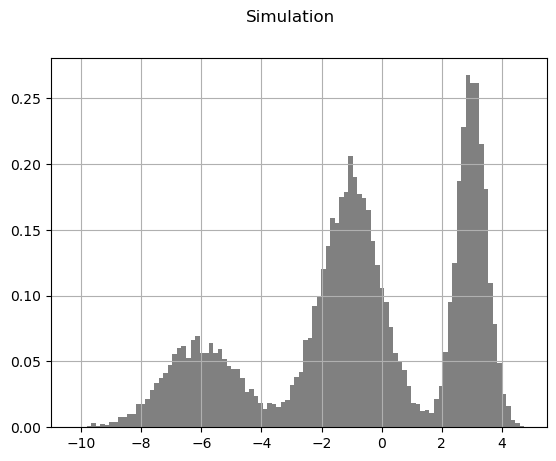

In [36]:
np.random.seed(24)

mu = np.array([-6, -1, 3])
Sig = np.array([1.25, 1., 0.5])
pi = np.array([3000/15000, 7000/15000, 5000/15000])
theta = np.concatenate([pi, mu, Sig])

Y1 = np.random.normal(mu[0], Sig[0], 3000)
Y2 = np.random.normal(mu[1], Sig[1], 7000)
Y3 = np.random.normal(mu[2], Sig[2], 5000)
Y = np.concatenate([Y1, Y2, Y3])
np.random.shuffle(Y)

Y = Y.reshape(-1, 1)
plt.hist(Y, bins=100, density=True, color='gray')
plt.grid()
plt.suptitle("Simulation")

**Descente de gradient classique :**

In [39]:
theta0 = random_theta0(Y.flatten(), 0)
theta_est, z_est, steps = SGD(Y, theta0, n_iter=5000)

In [40]:
theta_est

array([ 0.20238533,  0.46470525, -6.00207761, -0.99505834,  2.99246684,
        1.74001439,  0.96957547,  0.24362897])

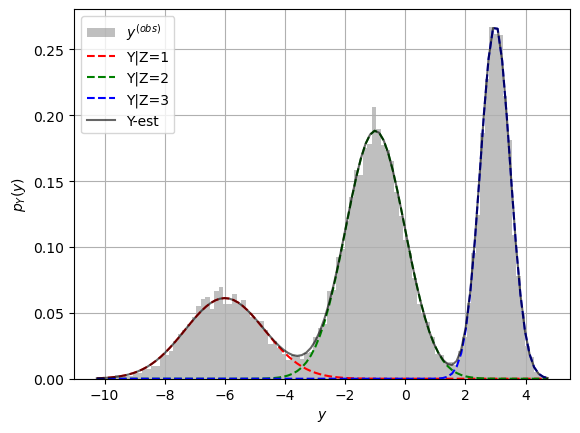

In [41]:
plot_estimate(Y, theta_est)

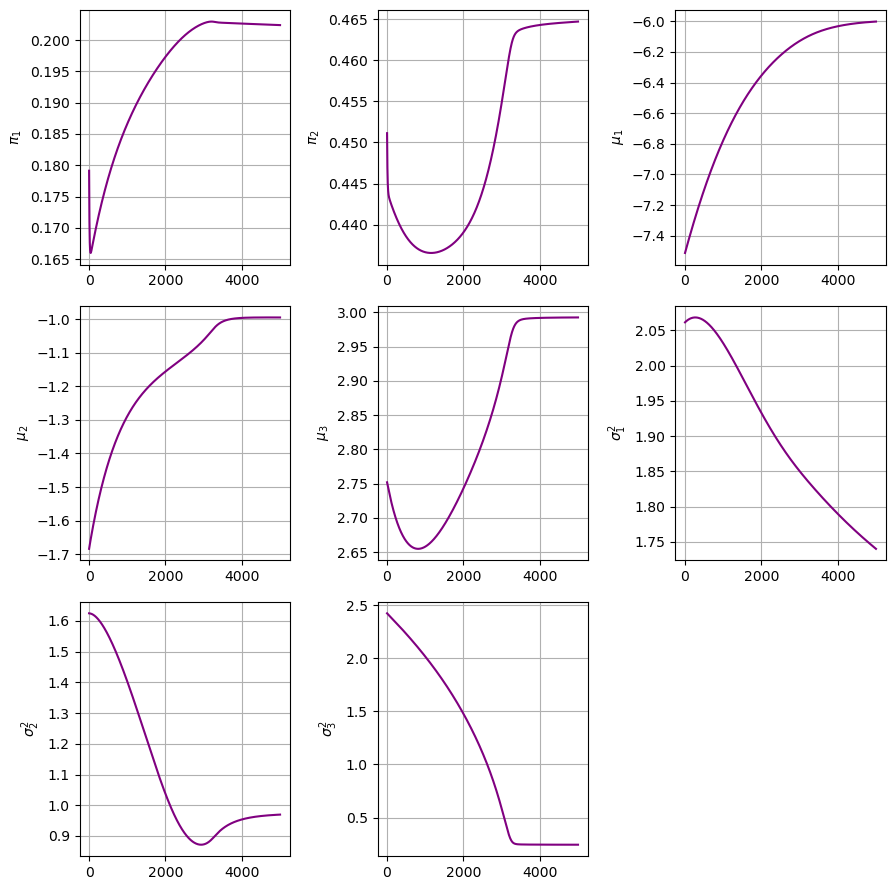

In [45]:
plot_converge(steps)
plt.tight_layout()

**Descente de gradient stochastique avec conditionement et heating :**

In [48]:
theta0 = random_theta0(Y.flatten(), 0)
theta_est, z_est, steps, gammas, Isteps = SGDFisher(Y, theta0, n_iter=5000)

In [49]:
theta_est

array([ 0.20023581,  0.46701979, -6.02052203, -1.00368581,  2.99302076,
        1.52658218,  0.99189053,  0.24307229])

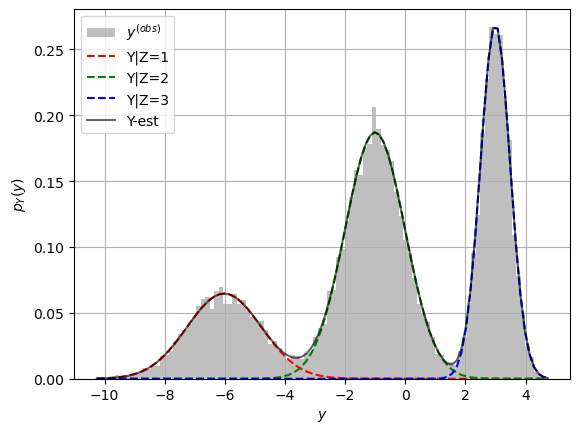

In [50]:
plot_estimate(Y, theta_est)

*Convergence du paramètre :*

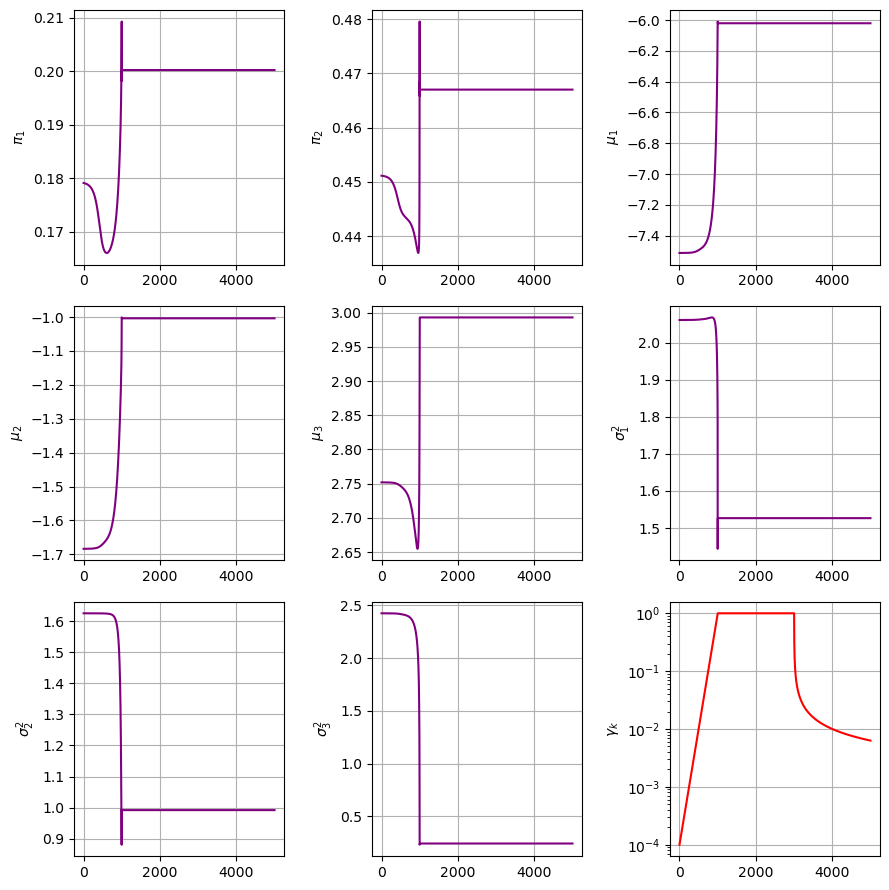

In [56]:
plot_converge(steps, gammas)
plt.tight_layout()

*Eléments diagonaux de l'estimation de fisher :*

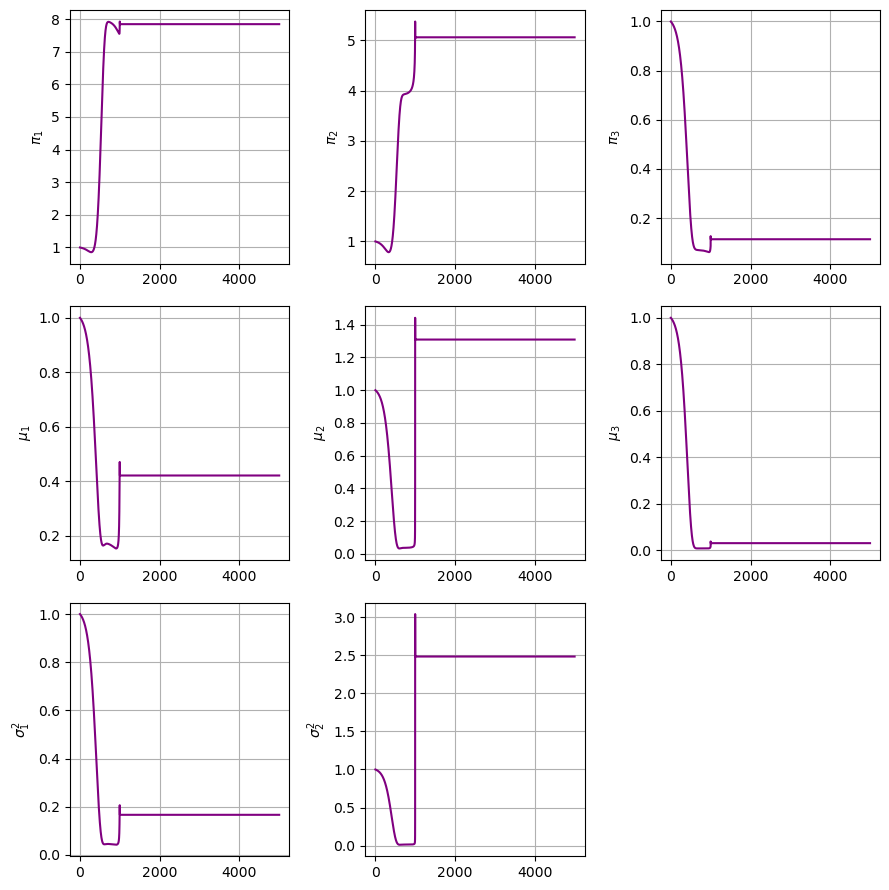

In [59]:
plot_fish_est(Isteps)
plt.tight_layout()

### 5. Comparaison à plus grande échelle

*Performance à grande échelle sur plusieurs variations du modèle, paramètres initiaux et échantillons tirés :*

In [43]:
### /!\ TRES LONG /!\ 2h d'estimation ~ ###
### =================================== ###

import warnings
warnings.filterwarnings('ignore')

seeds = [0, 8, 20, 36, 42] 
P = len(seeds) # paramètres initiaux
N = 5000       # taille des échantillons
n_samples = 25 # nombre d'échantillons

models = [
    [-6, -1, 3, 1.25, 1., 0.5, 1/5, 7/15, 1/3],     # modèle de base
    [-4,  0, 2, 1.25, 1., 0.5, 1/5, 7/15, 1/3],     # esperances compactes
    [-6, -1, 3, 1.25, 1., 0.5, 1/15, 13/15, 1/15],  # proportions déséquilibrées
    [-6, -1, 3, 1., 1., 1., 1/5, 7/15, 1/3]         # même variance
]

idxs = ['p1', 'p2', 'mu1', 'mu2', 'mu3', 'sig21', 'sig22', 'sig23']
SGDScores = pd.DataFrame(index=idxs)
SGDFisherScores = pd.DataFrame(index=idxs)
ConvScores = pd.DataFrame(index=['SGD', 'FSGD'])

total_iter = len(models) * n_samples * P

with tqdm(total=total_iter) as pbar :
    
    for imod, model in enumerate(models) :
    
        ThetaSGD = []
        ThetaFisherSGD = []
    
        mu = model[:3]
        Sig = model[3:6]
        pi = model[6:9]
    
        n_div_SGD = 0
        n_div_FSGD = 0
    
        theta = np.concatenate([pi[:2], mu, np.array(Sig)**2])
    
        for i_sample in range(n_samples):
            
            np.random.seed(24 + i_sample)
            
            Y1 = np.random.normal(mu[0], Sig[0], int(pi[0] * N))
            Y2 = np.random.normal(mu[1], Sig[1], int(pi[1] * N))
            Y3 = np.random.normal(mu[2], Sig[2], int(pi[2] * N))
        
            Y = np.concatenate([Y1, Y2, Y3])
            np.random.shuffle(Y)
            
            Y = Y.reshape(-1, 1)
        
            
            for t, seed in enumerate(seeds) : 
                
                theta0 = random_theta0(Y.flatten(), seed)
                
                try : theta_est, _, _ = SGD(Y, theta0, n_iter=8000)
                except : theta_est = np.nan * np.zeros(8) 
                if pd.isna(theta_est).sum() > 0 or np.linalg.norm(theta_est - theta) > 10 : # non-convergence
                    # print(f'diverge-SGD - model:{imod}, sample:{i_sample}, seed:{seed}')
                    n_div_SGD += 1
                else :
                    ThetaSGD.append(theta_est)
                    
                try : Ftheta_est, _, _, _, _ = SGDFisher(Y, theta0, gamma0=1e-6, Kph=3000, Kh=4000, n_iter=8000)
                except : Ftheta_est = np.nan * np.zeros(8)
                if pd.isna(Ftheta_est).sum() > 0 or np.linalg.norm(Ftheta_est - theta) > 10 : # non-convergence 
                    # print(f'diverge-FSGD - model:{imod}, sample:{i_sample}, seed:{seed}')
                    n_div_FSGD += 1
                else :
                    ThetaFisherSGD.append(Ftheta_est)
                    if np.linalg.norm(Ftheta_est - theta) < best_Ftheta_score : 
                        best_Ftheta = Ftheta_est
                
                pbar.update(1)

        ThetaSGD = np.array(ThetaSGD)
        ThetaFisherSGD = np.array(ThetaFisherSGD)
        
        if len(ThetaSGD) > 0 : SGDScores[f'mod{imod}'] = np.sqrt( (1/len(ThetaSGD)) * np.nansum( (ThetaSGD - theta)**2, axis=0) )
        if len(ThetaFisherSGD) > 0 : SGDFisherScores[f'mod{imod}'] = np.sqrt( (1/len(ThetaFisherSGD)) * np.nansum( (ThetaFisherSGD - theta)**2, axis=0) )
        ConvScores[f'mod{imod}'] = [1-n_div_SGD/(P*n_samples), 1-n_div_FSGD/(P*n_samples)]
        
        SGDScores.to_csv('SGDScores.csv', index=False)
        SGDFisherScores.to_csv('SGDFisherScores.csv', index=False)
        ConvScores.to_csv('ConvScores.csv', index=False)

100%|██████████████████████████████████████████████████████████████████████████████| 500/500 [2:14:42<00:00, 16.17s/it]


*RMSE sur les estimateurs obtenus par SGD :*

In [68]:
SGDScores = pd.read_csv('SGDScores.csv')
SGDScores

,mod0,mod1,mod2,mod3
0,0.005796,0.678869,0.002147,0.962543
1,0.006812,0.455349,0.002630,1.245474
2,0.096475,0.378974,0.129642,0.113443
3,0.028673,0.460423,0.012089,0.613114
4,0.012972,0.160805,0.031032,0.842053
5,0.416323,0.252558,0.260233,0.618412
6,0.144254,0.383099,0.026136,1.661721
7,0.008680,0.177249,0.018244,0.407375


*RMSE sur les estimateurs obtenus par Fisher-SGD :*

In [74]:
SGDFisherScores = pd.read_csv('SGDFisherScores.csv')
SGDFisherScores

,mod0,mod1,mod2,mod3
0,0.001600,0.004202,0.001445,0.000932
1,0.001719,0.013855,0.001759,0.003039
2,0.038571,0.055158,0.059654,0.028362
3,0.018382,0.040513,0.011821,0.023287
4,0.011777,0.020784,0.030500,0.028801
5,0.071836,0.101366,0.139950,0.040743
6,0.038025,0.078745,0.020560,0.039136
7,0.008086,0.013832,0.017960,0.042277


*Visualisation de convergence pour le premier échantillon, modèle (base) :*

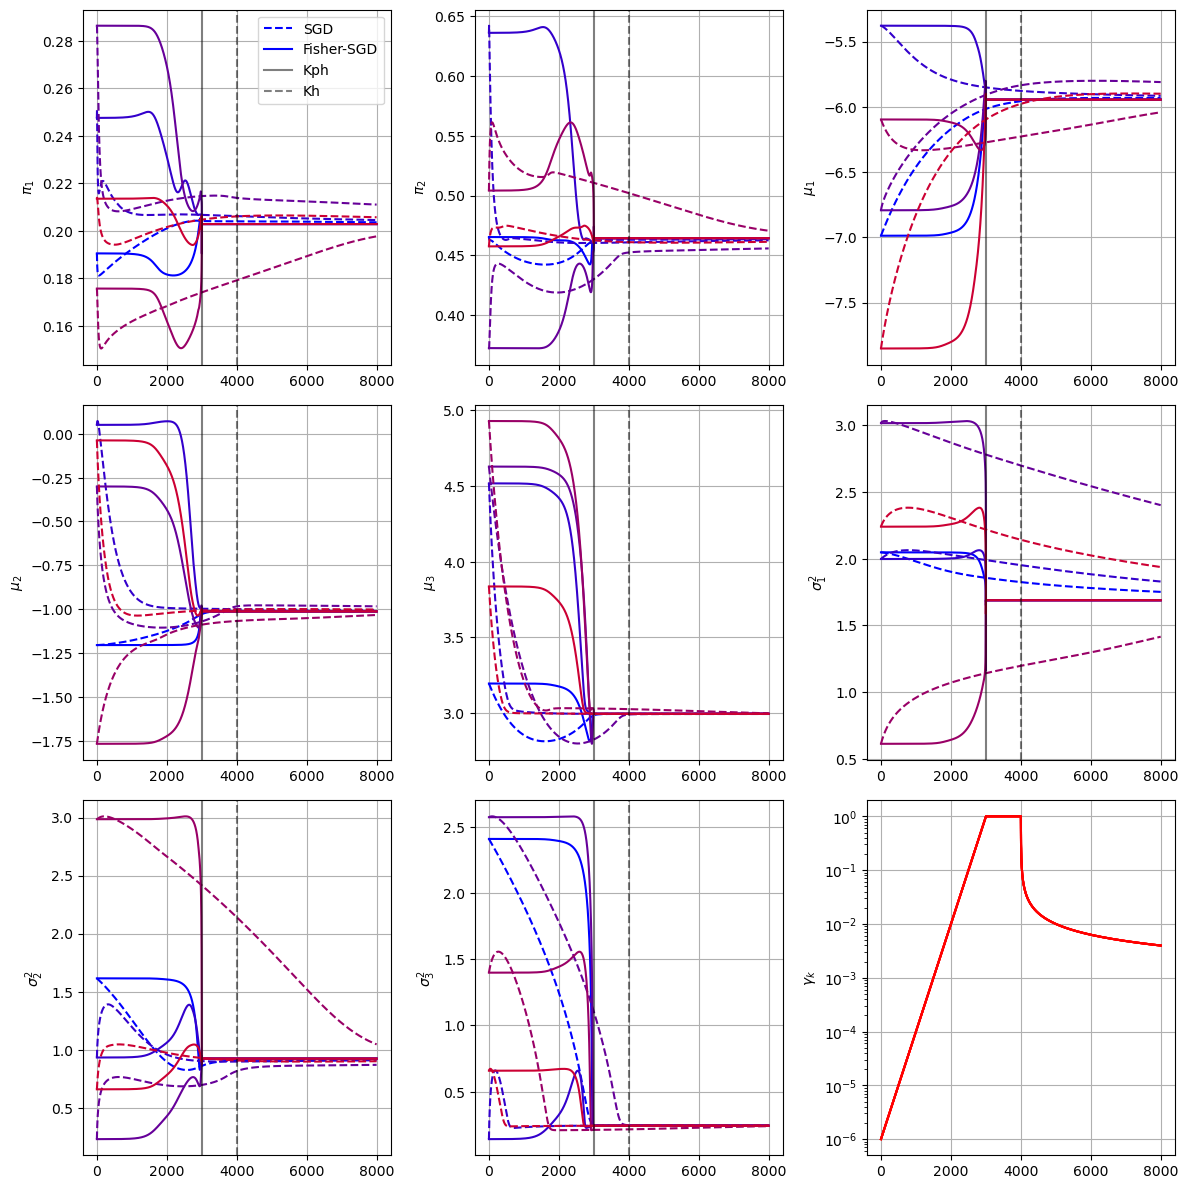

In [65]:
seeds = [0, 8, 20, 36, 42] 
P = len(seeds) # paramètres initiaux
N = 5000       # taille des échantillons
Kph = 3000
Kh = 4000

model0 = [-6, -1, 3, 1.25, 1., 0.5, 1/5, 7/15, 1/3]
mu = model0[:3]
Sig = model0[3:6]
pi = model0[6:9]

idxs = ['p1', 'p2', 'mu1', 'mu2', 'mu3', 'sig21', 'sig22', 'sig23']
names = ('$\\pi_1$', '$\\pi_2$', '$\\mu_1$', '$\\mu_2$', '$\\mu_3$', '$\\sigma_1^2$', '$\\sigma_2^2$', '$\\sigma_3^2$')
np.random.seed(24)
            
Y1 = np.random.normal(mu[0], Sig[0], int(pi[0] * N))
Y2 = np.random.normal(mu[1], Sig[1], int(pi[1] * N))
Y3 = np.random.normal(mu[2], Sig[2], int(pi[2] * N))
        
Y = np.concatenate([Y1, Y2, Y3])
np.random.shuffle(Y)
            
Y = Y.reshape(-1, 1)

fig, axs = plt.subplots(3, 3, figsize=(12, 12))

for t, seed in enumerate(seeds):

    theta0 = random_theta0(Y.flatten(), seed)

    _, _, SGDvals = SGD(Y, theta0, n_iter=8000)
    _, _, FSGDvals, gammas, _ = SGDFisher(Y, theta0, gamma0=1e-6, Kph=3000, Kh=4000, n_iter=8000)
    
    for i in range(3):
        for j in range(3):
            if i+j !=4 :
                k = 3*i + j
                axs[i,j].plot(SGDvals[:,k], color=(t/5,0,1 - t/5), linestyle='--', label='SGD'*(t==0))
                axs[i,j].plot(FSGDvals[:,k], color=(t/5,0,1 - t/5), label='Fisher-SGD'*(t==0))
                axs[i,j].set_ylabel(names[k])
                axs[i,j].grid(True)
            else : 
                axs[i, j].plot(gammas, color='red')
                axs[i, j].set_yscale('log')
                axs[i, j].set_ylabel('$\\gamma_k$')
                axs[i, j].grid(True)

for i in range(3):
    for j in range(3):
        if i+j != 4:
            ymin, ymax = axs[i,j].get_ylim()
            axs[i,j].plot([Kph, Kph], [ymin, ymax], color='black', alpha=0.5, label='Kph')
            axs[i,j].plot([Kh, Kh], [ymin, ymax], color='black', linestyle='--', alpha=0.5, label='Kh')
            axs[i,j].set_ylim(ymin, ymax)

axs[0, 0].legend()

plt.tight_layout()
plt.savefig(f'Figs/mod0_conv.png')

*Quelques densités estimées (pour lesquelles on a convergence des deux algorithmes) :*

*1-Modèle base*

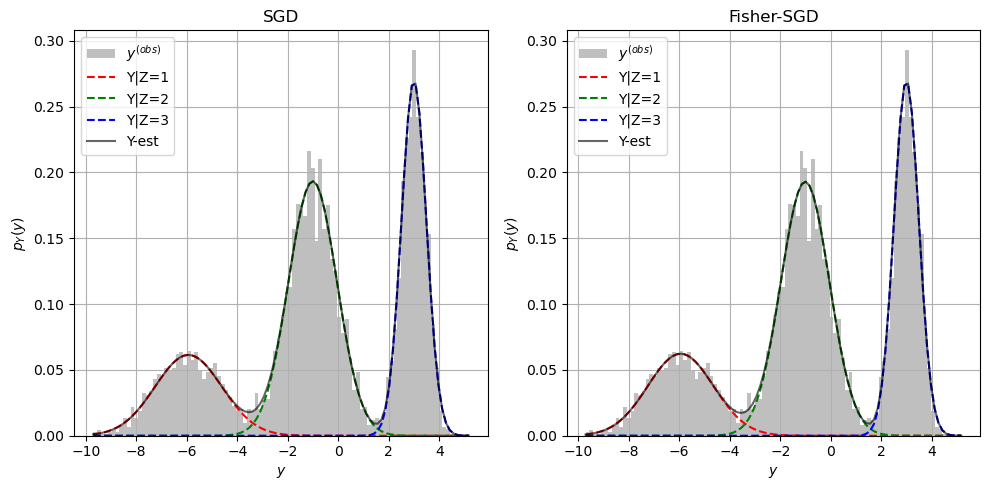

In [83]:
seed_theta0 = 0
seed_y = 24

np.random.seed(seed_y)

model = models[0]

mu = model[:3]
Sig = model[3:6]
pi = model[6:9]
theta = np.concatenate([pi, mu, Sig])
    
Y1 = np.random.normal(mu[0], Sig[0], int(pi[0] * 5000))
Y2 = np.random.normal(mu[1], Sig[1], int(pi[1] * 5000))
Y3 = np.random.normal(mu[2], Sig[2], int(pi[2] * 5000))

Y = np.concatenate([Y1, Y2, Y3])
np.random.shuffle(Y)
    
Y = Y.reshape(-1, 1)

fig, axs = plt.subplots(1, 2, figsize=(10, 5))

theta0 = random_theta0(Y.flatten(), seed_theta0)
theta_est_SGD, _, _ = SGD(Y, theta0, n_iter=8000)
theta_est_FSGD, _, _, _, _ = SGDFisher(Y, theta0, gamma0=1e-6, Kph=3000, Kh=4000, n_iter=8000)

plot_estimate(Y, theta_est_SGD, ax=axs[0])
plot_estimate(Y, theta_est_FSGD, ax=axs[1])
axs[0].set_title('SGD')
axs[1].set_title('Fisher-SGD')

plt.tight_layout()
plt.savefig('Figs/mod0.png')

*2 - Modèle à esperances compactes*

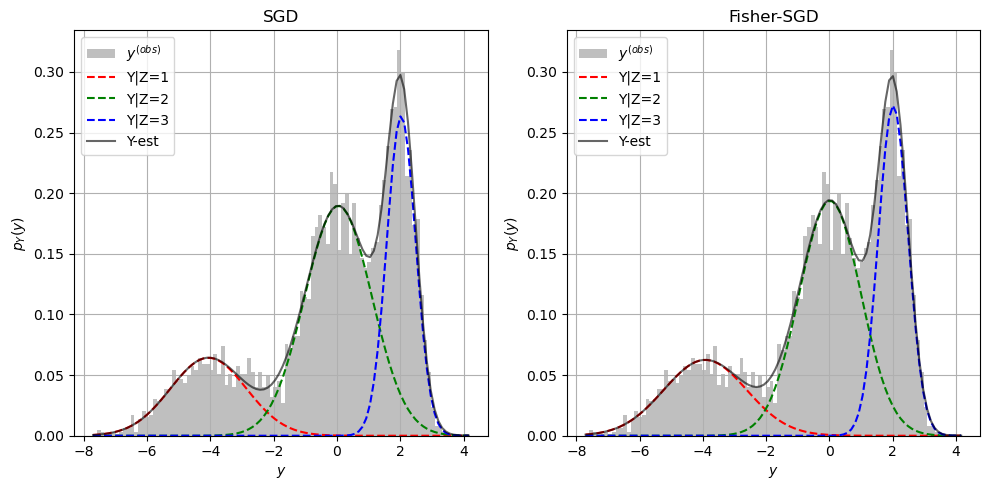

In [75]:
seed_theta0 = 0
seed_y = 24

np.random.seed(seed_y)

model = models[1]

mu = model[:3]
Sig = model[3:6]
pi = model[6:9]
theta = np.concatenate([pi, mu, Sig])
    
Y1 = np.random.normal(mu[0], Sig[0], int(pi[0] * 5000))
Y2 = np.random.normal(mu[1], Sig[1], int(pi[1] * 5000))
Y3 = np.random.normal(mu[2], Sig[2], int(pi[2] * 5000))

Y = np.concatenate([Y1, Y2, Y3])
np.random.shuffle(Y)
    
Y = Y.reshape(-1, 1)

fig, axs = plt.subplots(1, 2, figsize=(10, 5))

theta0 = random_theta0(Y.flatten(), seed_theta0)
theta_est_SGD, _, _ = SGD(Y, theta0, n_iter=8000)
theta_est_FSGD, _, _, _, _ = SGDFisher(Y, theta0, gamma0=1e-6, Kph=3000, Kh=4000, n_iter=8000)

plot_estimate(Y, theta_est_SGD, ax=axs[0])
plot_estimate(Y, theta_est_FSGD, ax=axs[1])
axs[0].set_title('SGD')
axs[1].set_title('Fisher-SGD')

plt.tight_layout()
plt.savefig('Figs/mod1.png')

*3 - Modèle à proportions déséquilibrées*

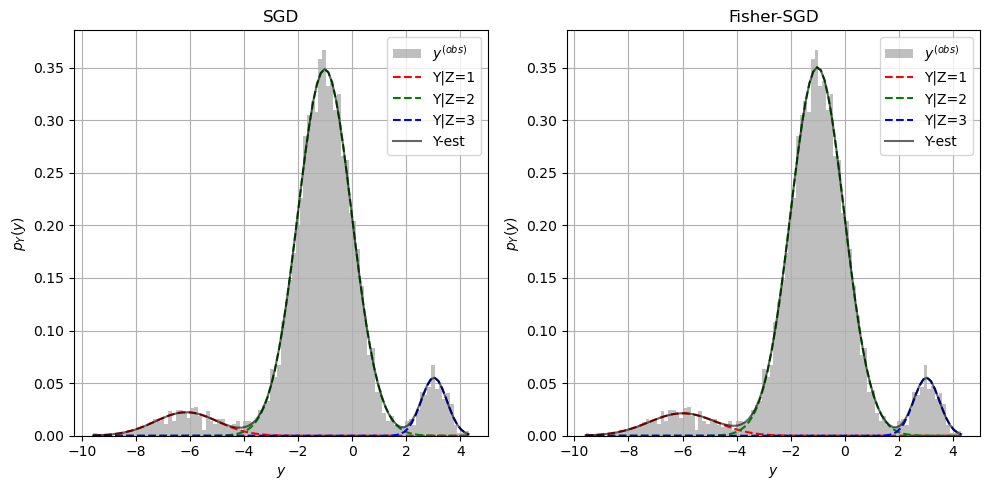

In [81]:
seed_theta0 = 42
seed_y = 24

np.random.seed(seed_y)

model = models[2]

mu = model[:3]
Sig = model[3:6]
pi = model[6:9]
theta = np.concatenate([pi, mu, Sig])
    
Y1 = np.random.normal(mu[0], Sig[0], int(pi[0] * 5000))
Y2 = np.random.normal(mu[1], Sig[1], int(pi[1] * 5000))
Y3 = np.random.normal(mu[2], Sig[2], int(pi[2] * 5000))

Y = np.concatenate([Y1, Y2, Y3])
np.random.shuffle(Y)
    
Y = Y.reshape(-1, 1)

fig, axs = plt.subplots(1, 2, figsize=(10, 5))

theta0 = random_theta0(Y.flatten(), seed_theta0)
theta_est_SGD, _, _ = SGD(Y, theta0, n_iter=8000)
theta_est_FSGD, _, _, _, _ = SGDFisher(Y, theta0, gamma0=1e-6, Kph=3000, Kh=4000, n_iter=8000)

plot_estimate(Y, theta_est_SGD, ax=axs[0])
plot_estimate(Y, theta_est_FSGD, ax=axs[1])
axs[0].set_title('SGD')
axs[1].set_title('Fisher-SGD')

plt.tight_layout()
plt.savefig('Figs/mod2.png')

*4  - Modèle avec variances identiques*

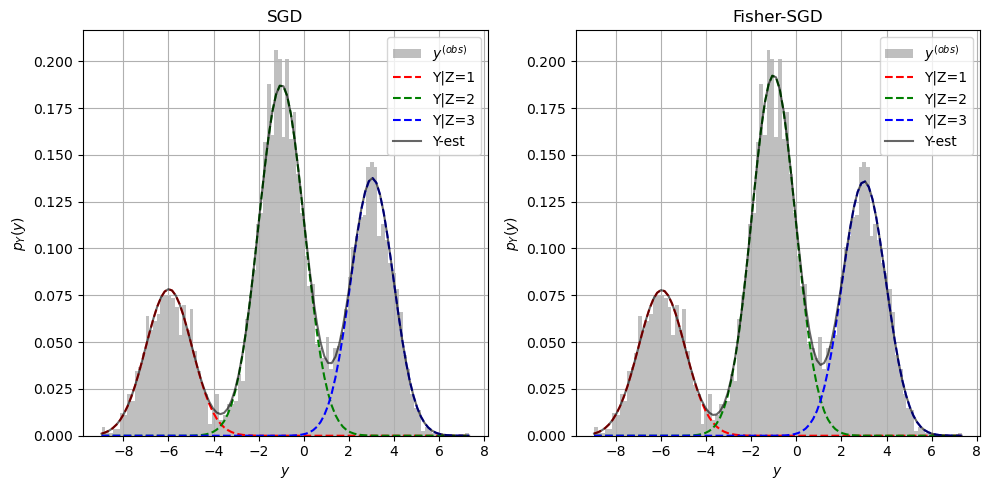

In [89]:
seed_theta0 = 0
seed_y = 24

np.random.seed(seed_y)

model = models[3]

mu = model[:3]
Sig = model[3:6]
pi = model[6:9]
theta = np.concatenate([pi, mu, Sig])
    
Y1 = np.random.normal(mu[0], Sig[0], int(pi[0] * 5000))
Y2 = np.random.normal(mu[1], Sig[1], int(pi[1] * 5000))
Y3 = np.random.normal(mu[2], Sig[2], int(pi[2] * 5000))

Y = np.concatenate([Y1, Y2, Y3])
np.random.shuffle(Y)
    
Y = Y.reshape(-1, 1)

fig, axs = plt.subplots(1, 2, figsize=(10, 5))

theta0 = random_theta0(Y.flatten(), seed_theta0)
theta_est_SGD, _, _ = SGD(Y, theta0, n_iter=8000)
theta_est_FSGD, _, _, _, _ = SGDFisher(Y, theta0, gamma0=1e-6, Kph=3000, Kh=4000, n_iter=8000)

plot_estimate(Y, theta_est_SGD, ax=axs[0])
plot_estimate(Y, theta_est_FSGD, ax=axs[1])
axs[0].set_title('SGD')
axs[1].set_title('Fisher-SGD')

plt.tight_layout()
plt.savefig('Figs/mod3.png')